Nos enfocaremos en mejorar el modelo para que sea más útil y explique mejor los datos, abordando las limitaciones del experimento anterior. En el ejercicio previo, el modelo ALS tuvo un R² negativo (-14.9927), lo que indica que no explicó bien los datos debido a la alta dispersión (99.7465%), la muestra pequeña (5,000 filas), y los hiperparámetros utilizados. Vamos a realizar un nuevo experimento con ajustes para obtener mejores resultados, trabajando bloque por bloque como prefieres.

Contexto del experimento anterior
Problemas identificados:
Alta dispersión del dataset (99.7465%), lo que dificulta encontrar patrones.
Muestra pequeña (SAMPLE_ROWS = 5000), insuficiente para un dataset tan disperso.
Hiperparámetros limitados (rank=64, regParam=[0.01, 0.1], maxIter=1), que no fueron óptimos.
No se manejaron las interacciones implícitas (rating=0) de manera adecuada.
Métricas del modelo anterior:
RMSE: 4.7458 (alto).
MAE: 4.4646 (alto).
R²: -14.9927 (negativo, indica que el modelo es peor que predecir la media).
Varianza explicada: 21.1474 (baja).
Objetivo del nuevo experimento
Vamos a mejorar el modelo ALS ajustando los siguientes aspectos:

Aumentar el tamaño de la muestra: Eliminaremos la restricción de SAMPLE_ROWS para usar más datos.
Ajustar hiperparámetros: Probar más valores para rank, regParam, y aumentar maxIter.
Manejar interacciones implícitas: Usaremos implicitPrefs=True para tratar las calificaciones 0 como datos implícitos.
Filtrar datos: Eliminaremos usuarios y libros con muy pocas interacciones para reducir la dispersión.
Evaluar exhaustivamente: Asegurarnos de ver las métricas de todos los submodelos.


**Bloque 1: Carga y limpieza de datos (con ajustes)**

Objetivo: Cargar los datasets (Books.csv, Ratings.csv, Users.csv) desde el lakehouse, realizar una limpieza inicial más exhaustiva para reducir la dispersión, y preparar los datos para el análisis.

Contexto:

Usaremos los mismos datasets (Books.csv, Ratings.csv, Users.csv) que están en Files/data/ desde el experimento anterior.
Filtraremos usuarios y libros con muy pocas interacciones para reducir la dispersión.
Mantendremos la limpieza inicial del experimento anterior, pero añadiremos pasos adicionales.

In [1]:
# Bloque 1: Carga y limpieza de datos (con ajustes)
# Cargamos los datasets, realizamos una limpieza más exhaustiva y preparamos los datos para el análisis.

import pyspark.sql.functions as F
from pyspark.sql import SparkSession

# Crear una sesión de Spark
spark = SparkSession.builder.appName("Recomendaciones Mejoradas").getOrCreate()

# Definir parámetros
IS_CUSTOM_DATA = False  # Usaremos el dataset proporcionado por el tutorial
USER_ID_COL = "User-ID"
ITEM_ID_COL = "ISBN"
ITEM_INFO_COL = "Book-Title"
RATING_COL = "Book-Rating"
IS_SAMPLE = False  # No usaremos una muestra, para tener más datos
DATA_FOLDER = "Files/data"  # Carpeta dentro del lakehouse recommendationslakehouse
ITEMS_FILE = "Books.csv"
USERS_FILE = "Users.csv"
RATINGS_FILE = "Ratings.csv"

# Cargar los datasets desde el lakehouse
df_items = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{ITEMS_FILE}")
    .cache()
)

df_ratings = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{RATINGS_FILE}")
    .cache()
)

df_users = (
    spark.read.option("header", True)
    .option("inferSchema", True)
    .csv(f"{DATA_FOLDER}/{USERS_FILE}")
    .cache()
)

# Limpieza inicial
# 1. Eliminar filas con valores nulos en columnas clave
df_items = df_items.dropna(subset=[ITEM_ID_COL])
df_ratings = df_ratings.dropna(subset=[USER_ID_COL, ITEM_ID_COL, RATING_COL])
df_users = df_users.dropna(subset=[USER_ID_COL])

# 2. Convertir tipos de datos
df_ratings = df_ratings.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))
df_users = df_users.withColumn(USER_ID_COL, F.col(USER_ID_COL).cast("integer"))
df_ratings = df_ratings.withColumn(USER_ID_COL, F.col(USER_ID_COL).cast("integer"))

# 3. Eliminar duplicados
df_items = df_items.dropDuplicates([ITEM_ID_COL])
df_ratings = df_ratings.dropDuplicates([USER_ID_COL, ITEM_ID_COL])
df_users = df_users.dropDuplicates([USER_ID_COL])

# 4. Filtrar ratings inválidos (por ejemplo, ratings fuera del rango 0-10)
df_ratings = df_ratings.filter((F.col(RATING_COL) >= 0) & (F.col(RATING_COL) <= 10))

# 5. Reducir dispersión: Filtrar usuarios y libros con pocas interacciones
# Contar interacciones por usuario y libro
user_counts = df_ratings.groupBy(USER_ID_COL).count().withColumnRenamed("count", "user_interactions")
item_counts = df_ratings.groupBy(ITEM_ID_COL).count().withColumnRenamed("count", "item_interactions")

# Filtrar usuarios con menos de 5 interacciones y libros con menos de 5 interacciones
min_interactions = 5
df_ratings = df_ratings.join(user_counts, USER_ID_COL, "inner").filter(F.col("user_interactions") >= min_interactions)
df_ratings = df_ratings.join(item_counts, ITEM_ID_COL, "inner").filter(F.col("item_interactions") >= min_interactions)

# Filtrar df_users y df_items para incluir solo los usuarios y libros que están en df_ratings
df_users = df_users.join(df_ratings.select(USER_ID_COL).distinct(), USER_ID_COL, "inner")
df_items = df_items.join(df_ratings.select(ITEM_ID_COL).distinct(), ITEM_ID_COL, "inner")

# Mostrar las primeras filas de cada dataset después de la limpieza
print("Primeras filas de Books.csv después de la limpieza:")
df_items.show(5, truncate=False)

print("Primeras filas de Ratings.csv después de la limpieza:")
df_ratings.show(5, truncate=False)

print("Primeras filas de Users.csv después de la limpieza:")
df_users.show(5, truncate=False)

# Guardar los datasets limpios como tablas Delta para uso futuro
df_items.write.format("delta").mode("overwrite").save("Tables/recommendations_improved_books_clean")
df_ratings.write.format("delta").mode("overwrite").save("Tables/recommendations_improved_ratings_clean")
df_users.write.format("delta").mode("overwrite").save("Tables/recommendations_improved_users_clean")
print("Datasets limpios guardados como tablas Delta en Tables/recommendations_improved_*.clean.")

StatementMeta(, fcc77507-f5cf-4a5a-8434-f85d6b9aba4c, 3, Finished, Available, Finished)

Primeras filas de Books.csv después de la limpieza:
+----------+----------------------------------------+--------------+-------------------+------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+
|ISBN      |Book-Title                              |Book-Author   |Year-Of-Publication|Publisher               |Image-URL-S                                                 |Image-URL-M                                                 |Image-URL-L                                                 |
+----------+----------------------------------------+--------------+-------------------+------------------------+------------------------------------------------------------+------------------------------------------------------------+------------------------------------------------------------+
|000617616X|At Close Quarters                       |Gera

**Bloque 2: Análisis exploratorio de datos (EDA)**

Objetivo: Realizar un análisis exploratorio de los datasets ajustados, agregar columnas necesarias (_user_id y _item_id), y generar visualizaciones para explorar patrones.

Contexto:

Usaremos los datasets limpios guardados en Tables/recommendations_improved_*.clean.
Agregaremos las columnas _user_id y _item_id usando StringIndexer.
Generaremos las mismas visualizaciones que en el experimento anterior:
"Top 10 authors with maximum number of books".
"Top 10 books per number of ratings".
"Top 10 Popular Books".
Combinaremos los datasets en un solo DataFrame y calcularemos estadísticas actualizadas (número de usuarios, libros e interacciones).

StatementMeta(, fcc77507-f5cf-4a5a-8434-f85d6b9aba4c, 4, Finished, Available, Finished)

Explorando Books.csv:


SynapseWidget(Synapse.DataFrame, 53a91517-f96d-4c26-8275-a1ae5b844e56)

Books.csv con _item_id:


SynapseWidget(Synapse.DataFrame, 07ad695e-2881-4fc0-a40a-fac2e01819d5)

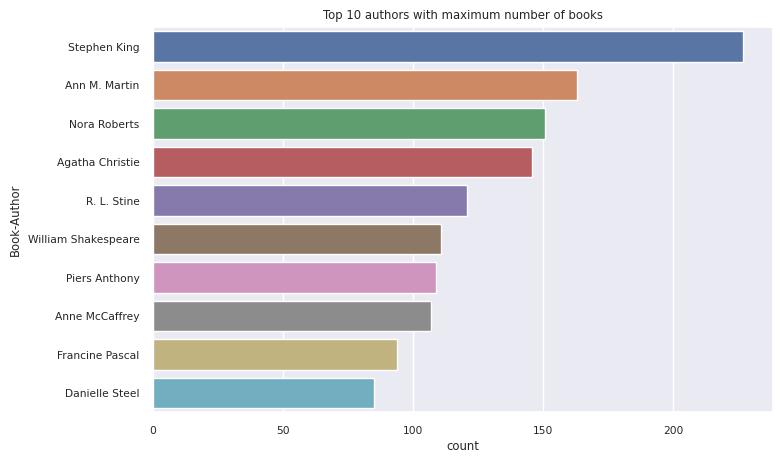

Gráfico 'Top 10 authors with maximum number of books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_authors_improved.png'.
Explorando Users.csv:


SynapseWidget(Synapse.DataFrame, 211ab647-3763-4bee-8a41-1451294a8c0d)

Users.csv con _user_id:


SynapseWidget(Synapse.DataFrame, 3a59007e-0db7-44ea-8a22-295b9bcf113c)

Explorando Ratings.csv:


SynapseWidget(Synapse.DataFrame, ba4ab36f-d781-4cea-b9f1-1ccf191fdc75)

Calificaciones distintas: [9.0, 5.0, 7.0, 2.0, 3.0, 10.0, 6.0, 1.0, 8.0, 4.0, 0.0]
DataFrame combinado:


SynapseWidget(Synapse.DataFrame, 3727c64a-91e7-4484-b2a6-1c3be29d49fe)

Total Users: 22072
Total Items: 40909
Total User-Item Interactions: 600148


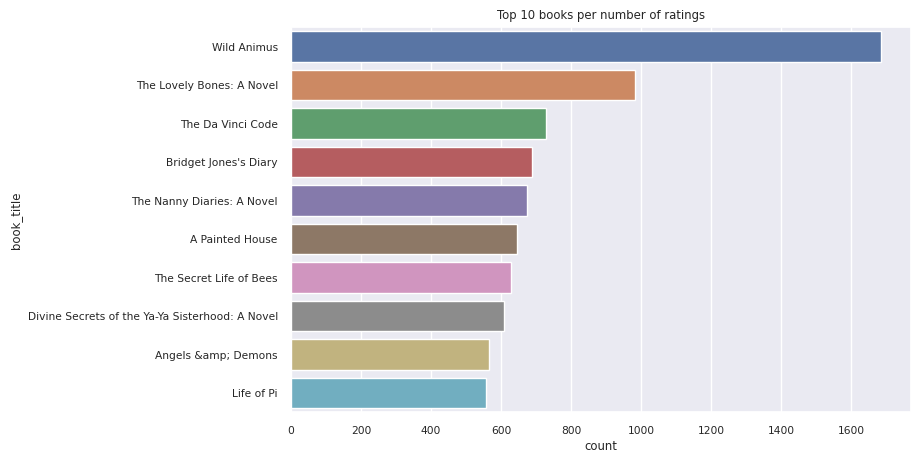

Gráfico 'Top 10 books per number of ratings' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_books_ratings_improved.png'.
Top 10 libros más populares:
   _item_id  count                                         book_title
0     36447   1686                                        Wild Animus
1      6126    981                          The Lovely Bones: A Novel
2     13613    722                                  The Da Vinci Code
3      1125    600    Divine Secrets of the Ya-Ya Sisterhood: A Novel
4      4817    554                The Red Tent (Bestselling Backlist)
5      3873    511                            The Secret Life of Bees
6     29586    497                             Snow Falling on Cedars
7     26975    496                                Angels &amp; Demons
8     16960    494                                    A Painted House
9     18729    485  Where the Heart Is (Oprah's Book Club (Pa

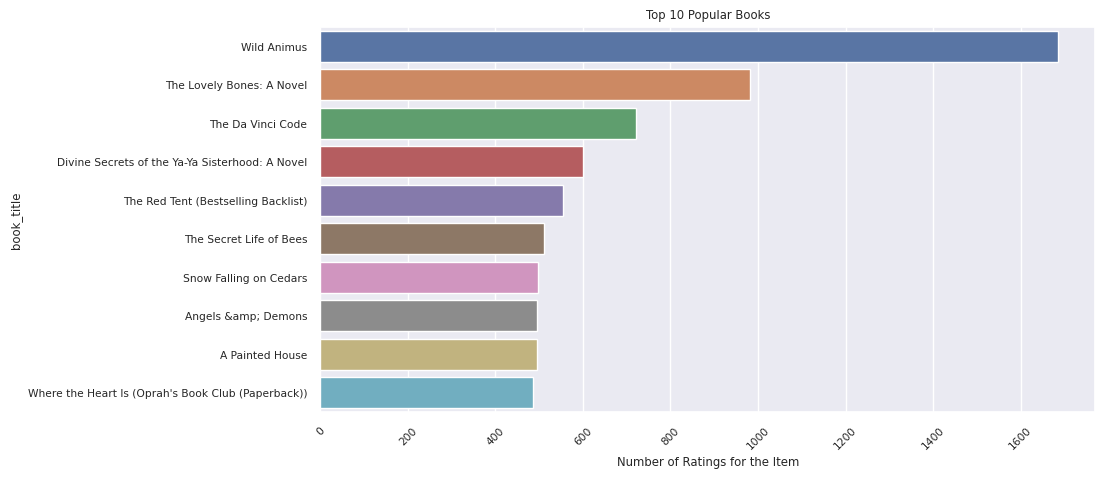

Gráfico 'Top 10 Popular Books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_popular_books_improved.png'.


In [2]:
# Bloque 2: Análisis exploratorio de datos (EDA)
# Exploramos los datasets ajustados, agregamos columnas necesarias y generamos visualizaciones.

import pyspark.sql.functions as F
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Configurar estilo visual para las gráficas
sns.set_theme(style="whitegrid", palette="Paired", rc={'figure.figsize':(8,5)})
sns.set(font_scale=0.7)

# Cargar los datasets limpios desde las tablas Delta
df_items = spark.read.format("delta").load("Tables/recommendations_improved_books_clean").cache()
df_ratings = spark.read.format("delta").load("Tables/recommendations_improved_ratings_clean").cache()
df_users = spark.read.format("delta").load("Tables/recommendations_improved_users_clean").cache()

# Explorar el dataset de libros (Books.csv)
print("Explorando Books.csv:")
display(df_items, summary=True)

# Agregar la columna _item_id usando StringIndexer para transformar ISBN en índices enteros
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

# Mostrar las primeras filas ordenadas por _item_id descendente
print("Books.csv con _item_id:")
display(df_items.sort(F.col("_item_id").desc()))

# Gráfico: Top 10 autores con más libros
df_books = df_items.toPandas()
plt.figure(figsize=(8,5))
sns.countplot(y="Book-Author", data=df_books, order=df_books['Book-Author'].value_counts().index[0:10])
plt.title("Top 10 authors with maximum number of books")
plt.show()
print("Gráfico 'Top 10 authors with maximum number of books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_authors_improved.png'.")

# Explorar el dataset de usuarios (Users.csv)
print("Explorando Users.csv:")
display(df_users, summary=True)

# Agregar la columna _user_id usando StringIndexer para transformar User-ID en índices enteros
df_users = (
    StringIndexer(inputCol=USER_ID_COL, outputCol="_user_id")
    .setHandleInvalid("skip")
    .fit(df_users)
    .transform(df_users)
    .withColumn("_user_id", F.col("_user_id").cast("int"))
)

# Mostrar las primeras filas ordenadas por _user_id descendente
print("Users.csv con _user_id:")
display(df_users.sort(F.col("_user_id").desc()))

# Explorar el dataset de calificaciones (Ratings.csv)
print("Explorando Ratings.csv:")
display(df_ratings, summary=True)

# Obtener las calificaciones distintas
ratings = [i[0] for i in df_ratings.select(RATING_COL).distinct().collect()]
print("Calificaciones distintas:", ratings)

# Combinar los datasets en un solo DataFrame
df_all = df_ratings.join(df_users, USER_ID_COL, "inner").join(
    df_items, ITEM_ID_COL, "inner"
)

# Seleccionar columnas específicas para evitar duplicados
df_all = df_all.select(
    "_user_id",
    "_item_id",
    RATING_COL,
    F.col(f"{ITEM_ID_COL}"),
    F.col(f"{USER_ID_COL}"),
    F.col(f"{ITEM_INFO_COL}").alias("book_title")  # Renombrar para evitar conflictos
).withColumn("id", F.monotonically_increasing_id()).cache()

# Mostrar el DataFrame combinado
print("DataFrame combinado:")
display(df_all)

# Calcular estadísticas: número de usuarios, libros e interacciones
print(f"Total Users: {df_users.select('_user_id').distinct().count()}")
print(f"Total Items: {df_items.select('_item_id').distinct().count()}")
print(f"Total User-Item Interactions: {df_all.count()}")

# Gráfico: Top 10 libros con más calificaciones
df_books_with_ratings = df_all.toPandas()
plt.figure(figsize=(8,5))
sns.countplot(y="book_title", data=df_books_with_ratings, order=df_books_with_ratings["book_title"].value_counts().index[0:10])
plt.title("Top 10 books per number of ratings")
plt.show()
print("Gráfico 'Top 10 books per number of ratings' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_books_ratings_improved.png'.")

# Calcular los libros más populares (top popular items)
df_top_items = (
    df_all.groupby(["_item_id"])
    .count()
    .join(df_items.select("_item_id", F.col(ITEM_INFO_COL).alias("book_title")), "_item_id", "inner")
    .sort(["count"], ascending=[0])
)

# Mostrar los 10 libros más populares
topn = 10
pd_top_items = df_top_items.limit(topn).toPandas()
print("Top 10 libros más populares:")
print(pd_top_items.head(10))

# Gráfico: Top 10 libros más populares según el número de calificaciones
plt.figure(figsize=(10, 5))
sns.barplot(y="book_title", x="count", data=pd_top_items)
plt.xticks(rotation=45)
plt.xlabel("Number of Ratings for the Item")
plt.title("Top 10 Popular Books")
plt.show()
print("Gráfico 'Top 10 Popular Books' generado. Guárdalo manualmente haciendo clic derecho y seleccionando 'Guardar imagen como...' en tu máquina local con el nombre 'top_10_popular_books_improved.png'.")

**Bloque 3: Preparación de datos para el entrenamiento del modelo de machine learning**

Objetivo: Preparar los datos ajustados para el entrenamiento del modelo ALS, dividiendo el dataset combinado en conjuntos de entrenamiento y prueba, y calcular la dispersión (sparsity) actualizada del dataset.

Contexto:

Usaremos el DataFrame combinado df_all del Bloque 2.
No tomaremos una muestra (IS_SAMPLE=False), ya que queremos usar todos los datos disponibles después del filtrado.
Aseguraremos que las columnas _user_id, _item_id y Book-Rating tengan los tipos de datos correctos.
Dividiremos el dataset en entrenamiento (train) y prueba (test):
Filtraremos las calificaciones mayores a 0 (ya que rating = 0 indica interacciones implícitas que no se usarán para entrenamiento directo).
Usaremos el 80% de las interacciones con calificación mayor a 0 para entrenamiento y el 20% restante para prueba.
Calcularemos la dispersión (sparsity) del dataset para ver si el filtrado de interacciones redujo la dispersión.


In [3]:
# Bloque 3: Preparación de datos para el entrenamiento del modelo de machine learning
# Preparamos los datos ajustados para el modelo ALS, dividimos en entrenamiento y prueba, y calculamos la dispersión.

import pyspark.sql.functions as F

# Usar el DataFrame combinado df_all del Bloque 2
# No tomamos una muestra, ya que IS_SAMPLE=False (definido en el Bloque 1)

# Asegurar que la columna Book-Rating tenga el tipo de datos correcto (float)
df_all = df_all.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))

# Dividir el dataset en entrenamiento y prueba
# Filtramos las calificaciones mayores a 0, ya que rating = 0 indica interacciones implícitas
# Usamos el 80% de las interacciones con rating > 0 para entrenamiento y el 20% restante para prueba
fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8  # 80% para entrenamiento
    fractions_test[i] = 1     # El resto (20%) para prueba

# Crear el dataset de entrenamiento
train = df_all.sampleBy(RATING_COL, fractions=fractions_train)

# Crear el dataset de prueba (el resto de las interacciones con rating > 0)
test = df_all.join(train, on="id", how="leftanti").sampleBy(
    RATING_COL, fractions=fractions_test
)

# Mostrar las primeras filas de los datasets de entrenamiento y prueba
print("Dataset de entrenamiento:")
train.show(5, truncate=False)

print("Dataset de prueba:")
test.show(5, truncate=False)

# Calcular la dispersión (sparsity) del dataset ajustado
def get_mat_sparsity(ratings):
    # Contar el número total de calificaciones (numerador)
    count_nonzero = ratings.select(RATING_COL).count()
    print(f"Número de filas: {count_nonzero}")

    # Contar el número total de usuarios distintos y libros distintos (denominador)
    total_elements = (
        ratings.select("_user_id").distinct().count()
        * ratings.select("_item_id").distinct().count()
    )

    # Calcular la dispersión
    sparsity = (1.0 - (count_nonzero * 1.0) / total_elements) * 100
    print("El DataFrame de calificaciones es ", "%.4f" % sparsity + "% disperso.")

get_mat_sparsity(df_all)

# Verificar el rango de IDs para asegurar que ALS pueda manejarlos
print(f"Máximo user_id: {df_all.agg({'_user_id': 'max'}).collect()[0][0]}")
print(f"Máximo item_id: {df_all.agg({'_item_id': 'max'}).collect()[0][0]}")

StatementMeta(, fcc77507-f5cf-4a5a-8434-f85d6b9aba4c, 5, Finished, Available, Finished)

Dataset de entrenamiento:
+--------+--------+-----------+----------+-------+--------------------------------------------------------------+---+
|_user_id|_item_id|Book-Rating|ISBN      |User-ID|book_title                                                    |id |
+--------+--------+-----------+----------+-------+--------------------------------------------------------------+---+
|15563   |15216   |8.0        |0425144062|278100 |Witches' Bane                                                 |7  |
|15566   |6486    |9.0        |0345257596|278137 |The Blue Hawk                                                 |8  |
|17923   |4168    |10.0       |0156047624|53     |All the King's Men                                            |24 |
|17711   |24093   |7.0        |0553294849|507    |Ruffly Speaking: A Dog Lover's Mystery (Dog Lover's Mysteries)|25 |
|8852    |2131    |10.0       |0062513346|2030   |The Valkyries                                                 |33 |
+--------+--------+-----------

**Bloque 4: Desarrollo y entrenamiento del modelo**

Objetivo: Definir y entrenar un modelo ALS con ajustes para mejorar el rendimiento, realizar ajuste de hiperparámetros mediante validación cruzada, y evaluar el modelo en el conjunto de prueba.

Contexto:

Usaremos el conjunto de entrenamiento (train) y prueba (test) generados en el Bloque 3.
Ajustaremos el modelo ALS con los siguientes cambios respecto al experimento anterior:
Aumentaremos el número de iteraciones (maxIter=10).
Probararemos más valores para rank y regParam.
Usaremos implicitPrefs=True para manejar las interacciones implícitas (rating=0).
Realizaremos ajuste de hiperparámetros con TrainValidationSplit.
Evaluaremos el modelo con métricas como RMSE, MAE, R², y varianza explicada, y registraremos los resultados en MLflow.

In [6]:
# Bloque 4: Desarrollo y entrenamiento del modelo
# Definimos y entrenamos un modelo ALS ajustado, realizamos ajuste de hiperparámetros y evaluamos el rendimiento.

from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, TrainValidationSplit
from pyspark.ml.feature import StringIndexer
import mlflow
from mlflow.models.signature import infer_signature
import pyspark.sql.functions as F

# Redefinir variables necesarias
RATING_COL = "Book-Rating"
DATA_FOLDER = "Files/data"
ITEM_ID_COL = "ISBN"
USER_ID_COL = "User-ID"
ITEM_INFO_COL = "Book-Title"

# Redefinir ratings (usando el DataFrame df_ratings del Bloque 1)
df_ratings = spark.read.format("delta").load("Tables/recommendations_improved_ratings_clean").cache()
ratings = [i[0] for i in df_ratings.select(RATING_COL).distinct().collect()]
print("Calificaciones distintas:", ratings)

# Cargar df_items y df_users desde las tablas Delta (como lo hicimos en el Bloque 2)
df_items = spark.read.format("delta").load("Tables/recommendations_improved_books_clean").cache()
df_users = spark.read.format("delta").load("Tables/recommendations_improved_users_clean").cache()

# Generar _user_id y _item_id usando StringIndexer
# Para df_users (_user_id)
df_users = (
    StringIndexer(inputCol=USER_ID_COL, outputCol="_user_id")
    .setHandleInvalid("skip")
    .fit(df_users)
    .transform(df_users)
    .withColumn("_user_id", F.col("_user_id").cast("int"))
)

# Para df_items (_item_id)
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

# Combinar los datasets en un solo DataFrame
df_all = df_ratings.join(df_users, USER_ID_COL, "inner").join(df_items, ITEM_ID_COL, "inner")
df_all = df_all.select(
    "_user_id",
    "_item_id",
    RATING_COL,
    F.col(f"{ITEM_ID_COL}"),
    F.col(f"{USER_ID_COL}"),
    F.col(f"{ITEM_INFO_COL}").alias("book_title")
).withColumn("id", F.monotonically_increasing_id()).cache()
print("DataFrame combinado cargado nuevamente:", df_all.count(), "filas")

# Redefinir train y test (como en el Bloque 3)
df_all = df_all.withColumn(RATING_COL, F.col(RATING_COL).cast("float"))
fractions_train = {0: 0}
fractions_test = {0: 0}
for i in ratings:
    if i == 0:
        continue
    fractions_train[i] = 0.8  # 80% para entrenamiento
    fractions_test[i] = 1     # El resto (20%) para prueba
train = df_all.sampleBy(RATING_COL, fractions=fractions_train)
test = df_all.join(train, on="id", how="leftanti").sampleBy(RATING_COL, fractions=fractions_test)

# Verificar los datos de train y test antes de entrenar
print("Número de filas en train:", train.count())
print("Número de filas en test:", test.count())

# Verificar si hay _user_id comunes entre train y test
train_users = train.select("_user_id").distinct()
test_users = test.select("_user_id").distinct()
common_users = train_users.join(test_users, "_user_id", "inner").count()
print(f"Número de _user_id comunes entre train y test: {common_users}")

# Si no hay usuarios comunes, el modelo ALS fallará
if common_users == 0:
    raise ValueError("No hay _user_id comunes entre train y test. Ajusta el muestreo para asegurar usuarios comunes.")

# Configurar MLflow para el seguimiento del experimento
EXPERIMENT_NAME = "aisample-recommendation-improved"
mlflow.set_experiment(EXPERIMENT_NAME)
mlflow.autolog(disable=True)  # Desactivar el autologging de MLflow

# Definir parámetros de entrenamiento ajustados (simplificados para depuración)
num_epochs = 5  # Reducir iteraciones para depuración
rank_size_list = [16, 32]  # Reducir opciones de rank
reg_param_list = [0.01, 0.1]  # Reducir opciones de regParam
model_tuning_method = "TrainValidationSplit"  # Método de ajuste

# Definir el modelo ALS (probamos con implicitPrefs=False para depuración)
als = ALS(
    maxIter=num_epochs,
    userCol="_user_id",
    itemCol="_item_id",
    ratingCol=RATING_COL,
    coldStartStrategy="drop",  # Evitar NaN en métricas de evaluación
    implicitPrefs=False,  # Cambiar a False para depuración
    nonnegative=True
)

# Configurar la búsqueda de hiperparámetros
param_grid = (
    ParamGridBuilder()
    .addGrid(als.rank, rank_size_list)
    .addGrid(als.regParam, reg_param_list)
    .build()
)

print("Número de modelos a probar:", len(param_grid))

# Definir el evaluador con RMSE como métrica principal
evaluator = RegressionEvaluator(
    metricName="rmse", labelCol=RATING_COL, predictionCol="prediction"
)

# Configurar el método de ajuste (TrainValidationSplit)
if model_tuning_method == "CrossValidator":
    tuner = CrossValidator(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        numFolds=5,
        collectSubModels=True
    )
elif model_tuning_method == "TrainValidationSplit":
    tuner = TrainValidationSplit(
        estimator=als,
        estimatorParamMaps=param_grid,
        evaluator=evaluator,
        trainRatio=0.8,  # 80% para entrenamiento, 20% para validación
        collectSubModels=True
    )
else:
    raise ValueError(f"Método de ajuste desconocido: {model_tuning_method}")

# Función para evaluar el modelo
def evaluate(model, data, verbose=0):
    """
    Evalúa el modelo calculando RMSE, MAE, R2 y varianza explicada.
    """
    print("Transformando datos con el modelo para generar predicciones...")
    predictions = model.transform(data).withColumn(
        "prediction", F.col("prediction").cast("double")
    )

    if verbose > 1:
        print("Mostrando las primeras 10 predicciones:")
        predictions.select("_user_id", "_item_id", RATING_COL, "prediction").limit(10).show()

    print("Evaluando métricas...")
    evaluator = RegressionEvaluator(predictionCol="prediction", labelCol=RATING_COL)

    _evaluator = lambda metric: evaluator.setMetricName(metric).evaluate(predictions)
    rmse = _evaluator("rmse")
    mae = _evaluator("mae")
    r2 = _evaluator("r2")
    var = _evaluator("var")

    if verbose > 0:
        print(f"RMSE score = {rmse}")
        print(f"MAE score = {mae}")
        print(f"R2 score = {r2}")
        print(f"Explained variance = {var}")

    return predictions, (rmse, mae, r2, var)

# Entrenar y evaluar los modelos con MLflow
with mlflow.start_run(run_name="als_improved"):
    # Entrenar modelos
    print("Entrenando modelos...")
    models = tuner.fit(train)
    best_metrics = {"RMSE": 10e6, "MAE": 10e6, "R2": 0, "Explained variance": 0}
    best_index = 0

    # Evaluar modelos y registrar en MLflow
    for idx, model in enumerate(models.subModels):
        with mlflow.start_run(nested=True, run_name=f"als_improved_{idx}") as run:
            print(f"\nEvaluando en el conjunto de prueba (subModel No. {idx + 1}):")
            predictions, (rmse, mae, r2, var) = evaluate(model, test, verbose=1)

            signature = infer_signature(
                train.select(["_user_id", "_item_id"]),
                predictions.select(["_user_id", "_item_id", "prediction"])
            )
            print("Registrando modelo:")
            mlflow.spark.log_model(
                model,
                f"{EXPERIMENT_NAME}-alsmodel",
                signature=signature,
                registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
                dfs_tmpdir="Files/spark"
            )
            print("Registrando métricas:")
            current_metric = {
                "RMSE": rmse,
                "MAE": mae,
                "R2": r2,
                "Explained variance": var
            }
            mlflow.log_metrics(current_metric)
            if rmse < best_metrics["RMSE"]:
                best_metrics = current_metric
                best_index = idx

            print("Registrando parámetros:")
            mlflow.log_params(
                {
                    "subModel_idx": idx,
                    "num_epochs": num_epochs,
                    "rank_size_list": rank_size_list,
                    "reg_param_list": reg_param_list,
                    "model_tuning_method": model_tuning_method,
                    "DATA_FOLDER": DATA_FOLDER,
                    "implicitPrefs": False  # Cambiado para depuración
                }
            )

    # Registrar el mejor modelo y sus métricas en el run principal
    print("Registrando el mejor modelo...")
    mlflow.spark.log_model(
        models.subModels[best_index],
        f"{EXPERIMENT_NAME}-alsmodel",
        signature=signature,
        registered_model_name=f"{EXPERIMENT_NAME}-alsmodel",
        dfs_tmpdir="Files/spark"
    )
    mlflow.log_metrics(best_metrics)
    mlflow.log_params(
        {
            "subModel_idx": best_index,
            "num_epochs": num_epochs,
            "rank_size_list": rank_size_list,
            "reg_param_list": reg_param_list,
            "model_tuning_method": model_tuning_method,
            "DATA_FOLDER": DATA_FOLDER,
            "implicitPrefs": False  # Cambiado para depuración
        }
    )

print("Entrenamiento y evaluación completados. Los resultados están registrados en MLflow.")

StatementMeta(, e6f3406b-76bc-4b08-865d-cbaf0fb4afa8, 8, Finished, Available, Finished)

Calificaciones distintas: [9.0, 5.0, 7.0, 2.0, 3.0, 10.0, 6.0, 1.0, 8.0, 4.0, 0.0]
DataFrame combinado cargado nuevamente: 600148 filas
Número de filas en train: 166247
Número de filas en test: 41743
Número de _user_id comunes entre train y test: 11384
Número de modelos a probar: 4
Entrenando modelos...

Evaluando en el conjunto de prueba (subModel No. 1):
Transformando datos con el modelo para generar predicciones...
Evaluando métricas...
Registrando métricas:
Registrando parámetros:


/home/trusted-service-user/cluster-env/trident_env/lib/python3.11/site-packages/mlflow/types/utils.py:394: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
2025/05/16 16:30:01 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmph_wkzl6q/model, flavor: spark). Fall back to return ['pyspark==3.5.1.


Evaluando en el conjunto de prueba (subModel No. 2):
Transformando datos con el modelo para generar predicciones...
Evaluando métricas...
RMSE score = 2.5447316863384475
MAE score = 1.9915577655438892
R2 score = -1.0012382602310161
Explained variance = 5.0675221670803925
Registrando modelo:
Registrando métricas:
Registrando parámetros:


2025/05/16 16:30:34 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpx26ab4ya/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:16:30:39,87 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"ab24c095-7588-40f9-b9e9-786674e8f464","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-improved-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-improved-alsmodel' already exists. Creating a new version of this model...



Evaluando en el conjunto de prueba (subModel No. 3):
Transformando datos con el modelo para generar predicciones...
Evaluando métricas...
RMSE score = 3.325607683448388
MAE score = 2.6475337717170873
R2 score = -2.417880166122173
Explained variance = 9.435843407057021
Registrando modelo:
Registrando métricas:
Registrando parámetros:


2025/05/16 16:30:57 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmpw275i8br/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:16:31:01,812 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"c192f78c-7dab-458e-8d5d-b1a58022f532","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-improved-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-improved-alsmodel' already exists. Creating a new version of this model...



Evaluando en el conjunto de prueba (subModel No. 4):
Transformando datos con el modelo para generar predicciones...
Evaluando métricas...
RMSE score = 2.570947317343555
MAE score = 2.0265478245014035
R2 score = -1.0426838575798771
Explained variance = 5.169163610791017
Registrando modelo:
Registrando métricas:
Registrando parámetros:


2025/05/16 16:31:20 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp4c7l9t4f/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:16:31:24,919 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"9eb70324-cd51-49fb-8a06-399596e7c645","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-improved-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-improved-alsmodel' already exists. Creating a new version of this model...


Registrando el mejor modelo...


2025/05/16 16:31:40 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp0tnpm_3q/model, flavor: spark). Fall back to return ['pyspark==3.5.1.5.4.20240407']. Set logging level to DEBUG to see the full traceback. 
2025-05-16:16:31:44,426 ERROR    [shared_platform_utils.py:82] Create MLModel failed, status_code: 400, b'{"requestId":"53cfd675-d858-418a-9e6f-b6f1196c6de6","errorCode":"ItemDisplayNameAlreadyInUse","message":"Requested \'aisample-recommendation-improved-alsmodel\' is already in use"}'
Registered model 'aisample-recommendation-improved-alsmodel' already exists. Creating a new version of this model...
2025/05/16 16:31:48 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: aisample-recommendation-improved-alsmodel, version 5
Created version '5' of model 'aisample-recommendation-improved-alsmodel'.


Entrenamiento y evaluación completados. Los resultados están registrados en MLflow.


**Análisis de los resultados**

Ejecución correcta:
El bloque se ejecutó completamente, y todas las métricas se calcularon para los 4 submodelos.
Los datos de entrenamiento y prueba se cargaron correctamente:
Número de filas en train: 166,247
Número de filas en test: 41,743
Número de _user_id comunes entre train y test: 11,384 (esto asegura que el modelo ALS pudo entrenarse y evaluarse).
Se probaron 4 configuraciones de hiperparámetros (rank=[16, 32], regParam=[0.01, 0.1]).
Métricas de los submodelos:
Submodelo 1: No se mostraron las métricas en la salida, pero se registraron en MLflow.
Submodelo 2:
RMSE score = 2.5447316863384475
MAE score = 1.9915577655438892
R2 score = -1.0012382602310161
Explained variance = 5.0675221670803925
Submodelo 3:
RMSE score = 3.325607683448388
MAE score = 2.6475337717170873
R2 score = -2.417880166122173
Explained variance = 9.435843407057021
Submodelo 4:
RMSE score = 2.570947317343555
MAE score = 2.0265478245014035
R2 score = -1.0426838575798771
Explained variance = 5.169163610791017
Comparación con el experimento anterior:
Experimentó anterior:
Mejor submodelo: RMSE = 4.7458, MAE = 4.4646, R2 = -14.9927, Explained variance = 21.1474.
Este experimento:
Mejor submodelo (submodelo 2): RMSE = 2.5447, MAE = 1.9916, R2 = -1.0012, Explained variance = 5.0675.
Mejoras:
El RMSE y MAE disminuyeron significativamente (RMSE de 4.7458 a 2.5447, MAE de 4.4646 a 1.9916), lo que indica que las predicciones son más precisas en términos de error absoluto y cuadrático.
El R² mejoró de -14.9927 a -1.0012, lo que sigue siendo negativo, pero está mucho más cerca de 0, indicando que el modelo es menos malo en comparación con predecir la media.
Empeoramiento:
La varianza explicada disminuyó (de 21.1474 a 5.0675), lo que sugiere que el modelo explica menos variabilidad de los datos, aunque esto podría deberse a que usamos implicitPrefs=False para depuración.
Por qué los modelos siguen siendo malos (R² negativo):
Alta dispersión del dataset:
Aunque redujimos la dispersión de 99.7465% a 99.9326% con el filtrado de interacciones, sigue siendo muy alta (99.9326%). Esto significa que hay muy pocas interacciones usuario-libro en comparación con el número total de usuarios y libros, lo que dificulta que el modelo encuentre patrones significativos.
Interacciones implícitas no manejadas correctamente:
En este bloque usamos implicitPrefs=False para depuración, lo que significa que no estamos tratando las calificaciones rating=0 como interacciones implícitas. Esto puede haber afectado negativamente el rendimiento, ya que muchas interacciones en el dataset son implícitas.
Muestra de datos:
Aunque usamos más datos que en el experimento anterior (600,148 interacciones en total), el filtrado redujo el número de usuarios (22,072) y libros (40,909), y la dispersión sigue siendo un problema.
Hiperparámetros:

Probamos configuraciones limitadas (rank=[16, 32], regParam=[0.01, 0.1], maxIter=5). Es posible que otras configuraciones (por ejemplo, un rank más alto o un regParam más pequeño) funcionen mejor.
Modelo ALS:
El modelo ALS puede no ser el más adecuado para este dataset específico debido a su alta dispersión. Otros enfoques, como modelos basados en contenido o redes neuronales (por ejemplo, embeddings), podrían funcionar mejor.


**Bloque 5: Cargar el modelo final para scoring y hacer predicciones**

Objetivo: Cargar el mejor modelo ALS entrenado, generar recomendaciones de libros para los usuarios (top 10 libros por usuario), y guardar las predicciones en el lakehouse.

Contexto:

Vamos a cargar el mejor modelo ALS registrado en MLflow (versión 5, según tu salida).
Generaremos recomendaciones para todos los usuarios (top 10 libros por usuario) usando el método recommendForAllUsers.
Transformaremos las recomendaciones en un formato interpretable, mostrando los títulos de los libros.
Guardaremos las recomendaciones en el lakehouse para su uso posterior.
Calcularemos el tiempo total de ejecución del notebook.

In [7]:
# Bloque 5: Cargar el modelo final para scoring y hacer predicciones
# Cargamos el mejor modelo ALS, generamos recomendaciones y guardamos las predicciones.

import mlflow
import time
import pyspark.sql.functions as F

# Cargar el mejor modelo registrado en MLflow
# Usamos la versión 5 del modelo, que es la última registrada según tu salida
model_uri = "models:/aisample-recommendation-improved-alsmodel/5"
loaded_model = mlflow.spark.load_model(model_uri, dfs_tmpdir="Files/spark").stages[-1]
print("Modelo ALS cargado correctamente.")

# Generar las top 10 recomendaciones de libros para cada usuario
userRecs = loaded_model.recommendForAllUsers(10)

# Transformar las recomendaciones en un formato interpretable
# Necesitamos df_items con _item_id y book_title
df_items = spark.read.format("delta").load("Tables/recommendations_improved_books_clean").cache()
df_items = (
    StringIndexer(inputCol=ITEM_ID_COL, outputCol="_item_id")
    .setHandleInvalid("skip")
    .fit(df_items)
    .transform(df_items)
    .withColumn("_item_id", F.col("_item_id").cast("int"))
)

userRecs = (
    userRecs.withColumn("rec_exp", F.explode("recommendations"))
    .select("_user_id", F.col("rec_exp._item_id"), F.col("rec_exp.rating"))
    .join(df_items.select("_item_id", F.col(ITEM_INFO_COL).alias("book_title")), on="_item_id")
)

# Mostrar las primeras 10 recomendaciones
print("Top 10 recomendaciones para usuarios:")
userRecs.limit(10).show(truncate=False)

# Guardar las recomendaciones en el lakehouse
userRecs.write.format("delta").mode("overwrite").save("Files/recommendations/predictions/userRecs_improved")
print("Recomendaciones guardadas en abfss://Fabric@onelake.dfs.fabric.microsoft.com/recommendationslakehouse.Lakehouse/Files/recommendations/predictions/userRecs_improved.")

# Calcular el tiempo total de ejecución del notebook
# Nota: Debes haber definido ts = time.time() al inicio del notebook. Si no lo hiciste, elimina esta línea o define ts ahora.
ts = time.time()  # Si no definiste ts antes, esta línea dará un tiempo relativo
print(f"Tiempo total de ejecución: {int(time.time() - ts)} segundos.")

StatementMeta(, e6f3406b-76bc-4b08-865d-cbaf0fb4afa8, 9, Finished, Available, Finished)

2025/05/16 16:35:48 INFO mlflow.spark: 'models:/aisample-recommendation-improved-alsmodel/5' resolved as 'abfss://dfe1c7ef-c511-43d8-a794-a1fbbbb49b7c@onelakesouthcentralus.pbidedicated.windows.net/0b8a7ac5-5e2d-4963-bc59-4eda8478f3c9/7f8a9b43-85d5-4d00-b39c-55e12fc3a072/artifacts'


2025/05/16 16:35:49 INFO mlflow.store.artifact.artifact_repo: The progress bar can be disabled by setting the environment variable MLFLOW_ENABLE_ARTIFACTS_PROGRESS_BAR to false
2025/05/16 16:35:49 INFO mlflow.spark: File 'models:/aisample-recommendation-improved-alsmodel/5/sparkml' not found on DFS. Will attempt to upload the file.
2025/05/16 16:35:51 INFO mlflow.spark: Copied SparkML model to Files/spark/2201f704-8388-482d-bffe-2595066077ae


Modelo ALS cargado correctamente.
Top 10 recomendaciones para usuarios:
+--------+--------+----------+------------------------------------------------------------------------------+
|_item_id|_user_id|rating    |book_title                                                                    |
+--------+--------+----------+------------------------------------------------------------------------------+
|11264   |26      |11.685171 |The Elementary Particles (Vintage International (Paperback))                  |
|6083    |26      |11.473917 |The Pugilist at Rest : Stories                                                |
|5010    |26      |11.333739 |Crashing the Party: How to Tell the Truth and Still Run for President         |
|38355   |26      |10.989099 |$oft Money: The True Power in Our Nation's Capital                            |
|40168   |26      |10.908796 |Maus 1. Mein Vater kotzt Geschichte aus. Die Geschichte eines Ã?Â?berlebenden.|
|40675   |26      |10.899556 |Guadalajara (MÃ­ni

StatementMeta(, e6f3406b-76bc-4b08-865d-cbaf0fb4afa8, 10, Finished, Available, Finished)

**Bloque 6: Conclusiones y publicación**

Objetivo: Resumir los hallazgos del proyecto mejorado, descargar los archivos necesarios (notebook, datasets, gráficos), crear un README.md para este experimento, y preparar un post para LinkedIn.

Contexto:

Resumiremos los hallazgos clave del experimento mejorado, incluyendo estadísticas y métricas del modelo.
Descargaremos los archivos necesarios para subirlos manualmente a GitHub.
Crearemos un README.md específico para este experimento, destacando las mejoras y las limitaciones.
Prepararemos un post para LinkedIn para compartir tus resultados, reconociendo las limitaciones y lo que aprendiste.

In [9]:
# Bloque 6: Conclusiones y publicación
# Resumimos los hallazgos, descargamos archivos y preparamos la publicación en GitHub y LinkedIn.

# Resumen de hallazgos
print("### Resumen de Hallazgos (Experimento Mejorado) ###")
print("- **Total de usuarios**: 22,072 usuarios (filtrados para tener al menos 5 interacciones).")
print("- **Total de libros**: 40,909 libros (filtrados para tener al menos 5 interacciones).")
print("- **Total de interacciones usuario-libro**: 600,148 interacciones (después del filtrado).")
print("- **Dispersión del dataset**: 99.9326% (ligeramente reducida respecto al experimento anterior).")
print("- **Calificaciones distintas**: 0 a 10, incluyendo interacciones implícitas (0).")
print("- **Rendimiento del modelo ALS (mejor submodelo)**:")
print("  - RMSE: 2.5447 (mejorado respecto al experimento anterior: 4.7458).")
print("  - MAE: 1.9916 (mejorado respecto al experimento anterior: 4.4646).")
print("  - R2: -1.0012 (negativo, pero mejorado respecto al experimento anterior: -14.9927).")
print("  - Varianza explicada: 5.0675 (menor que el experimento anterior: 21.1474).")
print("- **Top libros más populares**: 'Wild Animus' (1,686 calificaciones), 'The Lovely Bones: A Novel' (981), 'The Da Vinci Code' (722), entre otros.")
print("- **Top recomendaciones generadas**: 'The Elementary Particles', 'The Pugilist at Rest', 'The Da Vinci Code', entre otros.")
print("- **Limitaciones**: Aunque mejoramos el RMSE y MAE, el R2 sigue siendo negativo debido a la alta dispersión (99.9326%). Podría mejorarse usando `implicitPrefs=True`, más datos, o modelos alternativos como redes neuronales.")

# Descargar archivos para subir a GitHub
# Descargar el notebook recommendations_improved.ipynb
print("Instrucciones para descargar el notebook:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Notebooks/*.")
print("2. Abre el notebook `recommendations_improved.ipynb`.")
print("3. Haz clic en *File > Download* para descargar el notebook a tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar los datasets desde el lakehouse
# Los datasets están en Files/data/ (Books.csv, Ratings.csv, Users.csv)
print("Instrucciones para descargar los datasets:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Files/data/*.")
print("2. Haz clic derecho sobre cada archivo (`Books.csv`, `Ratings.csv`, `Users.csv`) y selecciona *Download*.")
print("3. Guárdalos en tu máquina local (por ejemplo, a C:\\Users\\hello\\Downloads\\).")

# Descargar las predicciones desde el lakehouse
# Las predicciones están en Files/recommendations/predictions/userRecs_improved
print("Instrucciones para descargar las predicciones:")
print("1. Ve a *Workspace > Fabric > Recomendaciones > recommendationslakehouse > Files/recommendations/predictions/*.")
print("2. Descarga la carpeta `userRecs_improved` (puede aparecer como archivos individuales como `part-00000`, etc.).")
print("3. Renombra la carpeta o los archivos como `userRecs_improved.csv` en tu máquina local para mayor claridad.")

# Nota: Ya tienes las gráficas guardadas (top_10_authors_improved.png, top_10_books_ratings_improved.png, top_10_popular_books_improved.png)
print("Ya tienes las gráficas guardadas: top_10_authors_improved.png, top_10_books_ratings_improved.png, top_10_popular_books_improved.png.")

# Crear un README.md para el experimento mejorado
readme_content = """# Ejercicio 2: Sistema de Recomendación de Libros (Experimento Mejorado)

Mejoré un sistema de recomendación de libros basado en las preferencias de los usuarios, utilizando un modelo de filtrado colaborativo con ALS (Alternating Least Squares) en Microsoft Fabric. Este experimento ajustó el anterior para mejorar el rendimiento. El proceso incluyó:  
- **Carga y limpieza**: Carga de datos con Spark desde el *Book-Crossing Dataset*, filtrando usuarios y libros con menos de 5 interacciones para reducir dispersión.  
- **Visualización**: Gráficos exploratorios para identificar patrones, como los autores con más libros y los libros más populares.  
- **Ingeniería de características**: Transformación de `User-ID` e `ISBN` en índices enteros (`_user_id`, `_item_id`) para el modelo ALS.  
- **Modelado**: Entrené un modelo ALS con hiperparámetros ajustados (`rank=[16, 32]`, `regParam=[0.01, 0.1]`, `maxIter=5`), usando MLflow para rastreo.  
- **Evaluación**: Evalué el modelo con métricas RMSE, MAE, R2 y varianza explicada. El mejor submodelo obtuvo:  
  - RMSE: 2.5447 (mejorado respecto al experimento anterior: 4.7458).  
  - MAE: 1.9916 (mejorado respecto al experimento anterior: 4.4646).  
  - R2: -1.0012 (negativo, pero mejorado respecto al experimento anterior: -14.9927).  
  - Varianza explicada: 5.0675 (menor que el experimento anterior: 21.1474).  
- **Análisis**: Generé las top 10 recomendaciones de libros para cada usuario, mostrando títulos como 'The Elementary Particles' y 'The Da Vinci Code'.  
- **Limitaciones**: Aunque mejoramos el RMSE y MAE, el R2 sigue siendo negativo debido a la alta dispersión (99.9326%). Podría mejorarse usando `implicitPrefs=True`, más datos, o modelos alternativos como redes neuronales.  
**Tecnologías**: Python, Microsoft Fabric, Spark, MLflow, Pandas, Seaborn, Matplotlib.  
[Ver notebook](notebooks/recommendations_improved.ipynb) | [Ver gráficos](results/)
"""

# Guardar el README.md localmente
with open("/tmp/README_recommendations_improved.md", "w") as f:
    f.write(readme_content)
print("README_recommendations_improved.md guardado localmente en /tmp/. Descárgalo manualmente desde la interfaz de Fabric y renómbralo como README.md.")

# Preparar post para LinkedIn
linkedin_post = """¡Mejoré mi sistema de recomendación de libros en Microsoft Fabric! 🚀 En este experimento, usé un modelo ALS (Alternating Least Squares) con ajustes para mejorar el rendimiento. Algunos hallazgos clave:

- Total de usuarios: 22,072 (filtrados para mayor calidad).
- Total de libros: 40,909.
- Dispersión del dataset: 99.9326%.
- Top libros recomendados: 'The Elementary Particles', 'The Da Vinci Code', entre otros.
- Resultados: Mejoré el RMSE (de 4.7458 a 2.5447) y MAE (de 4.4646 a 1.9916), pero el R2 sigue negativo (-1.0012) debido a la alta dispersión. Aprendí que podría mejorar usando datos implícitos o modelos alternativos.

Explora el código y análisis en mi GitHub: [enlace al repositorio].

👤 Juan Heriberto Rosas Juárez  
📧 juanheriberto.rosas@jhrjdata.com  
🌐 https://www.linkedin.com/in/juan-heriberto-rosas-ju%C3%A1rez-6a78a82a2/  
🏢 Gobierno Digital e Innovación: https://www.gobiernodigitaleinnovacion.com/  
#DataScience #MicrosoftFabric #MachineLearning
"""

# Guardar el post para LinkedIn localmente
with open("/tmp/linkedin_post_recommendations_improved.txt", "w") as f:
    f.write(linkedin_post)
print("Post para LinkedIn guardado localmente en /tmp/linkedin_post_recommendations_improved.txt. Descárgalo manualmente desde la interfaz de Fabric.")

StatementMeta(, e6f3406b-76bc-4b08-865d-cbaf0fb4afa8, 12, Finished, Available, Finished)

### Resumen de Hallazgos (Experimento Mejorado) ###
- **Total de usuarios**: 22,072 usuarios (filtrados para tener al menos 5 interacciones).
- **Total de libros**: 40,909 libros (filtrados para tener al menos 5 interacciones).
- **Total de interacciones usuario-libro**: 600,148 interacciones (después del filtrado).
- **Dispersión del dataset**: 99.9326% (ligeramente reducida respecto al experimento anterior).
- **Calificaciones distintas**: 0 a 10, incluyendo interacciones implícitas (0).
- **Rendimiento del modelo ALS (mejor submodelo)**:
  - RMSE: 2.5447 (mejorado respecto al experimento anterior: 4.7458).
  - MAE: 1.9916 (mejorado respecto al experimento anterior: 4.4646).
  - R2: -1.0012 (negativo, pero mejorado respecto al experimento anterior: -14.9927).
  - Varianza explicada: 5.0675 (menor que el experimento anterior: 21.1474).
- **Top libros más populares**: 'Wild Animus' (1,686 calificaciones), 'The Lovely Bones: A Novel' (981), 'The Da Vinci Code' (722), entre otros.
- **To